In [1]:
import os, re, time, json, math
import datetime
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import pandas as pd
import google
import pickle
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.1


In [2]:
import tensorflow as tf
import tensorflow.keras as keras

from src.generators.tf_records_generator import get_dataset, count_data_items
from src.models.efficientNet_B0 import EffNet0, freeze_blocks
from src.utils.log_files import save_config, save_fold_iter_history, get_log_dir, save_logs_pickle, generate_columns
from src.utils.kfold import get_kfold_split
from clr_schedule import CyclicLR
from src.utils.schedules import LR_test_schedule

In [3]:
CONFIG = dict(
    log_prefix = "CLR_",
    effnet_version = 0,
    input_shape=(256, 256, 3),
    image_resolution=256,
    trainable_base=False,
    time=datetime.datetime.now().strftime("_%d_%m_%Y_%H_%M"),
    use_patient_data=True,
    inner_blocks_frozen=4,

    lr_min=0.000001,
    lr_max=0.0001,
    lr_decay=None,
    clr_step_coefficient = 8,
    
    replicas=8,
    steps_per_epoch=20,
    validation_steps=20,
    batch_size=2,
    epochs=10,
    optimizer='adam',
    loss='binary_crossentropy',
    
    output_bias=np.log([584/32542]),
    weight_for_0 = (1 / 32542)*(32542+584)/2.0,
    weight_for_1 = (1 / 584)*(32542+584)/2.0
)

In [4]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()
  data_dir = 'gs://dataset_files/'
else:
  data_dir = 'dataset/'

In [5]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)
CONFIG["replicas"] = strategy.num_replicas_in_sync


Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [6]:
path = data_dir + str(CONFIG["image_resolution"])
files_train = np.sort(np.array(tf.io.gfile.glob(path + '/train*.tfrec')))
files_test = np.sort(np.array(tf.io.gfile.glob(path + '/test*.tfrec')))


test_ds = get_dataset(files_test, CONFIG)

In [7]:
def make_model(config:dict, strategy)    :
    with strategy.scope():
      model = EffNet0(config=config, trainable_base=config['trainable_base'])

      model.compile(optimizer=keras.optimizers.Adam(), loss=config["loss"], 
                    metrics=[
                                  keras.metrics.TruePositives(name='tp'),
                                  keras.metrics.FalsePositives(name='fp'),
                                  keras.metrics.TrueNegatives(name='tn'),
                                  keras.metrics.FalseNegatives(name='fn'), 
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall'),
                                  keras.metrics.AUC(name='auc'),
                            ]
    )
    return model

In [8]:
def train_validate(train_files, validation_files, config:dict):
    train_ds = get_dataset(train_files,config, patient_info=True,repeat=True) 
    val_ds = get_dataset(validation_files, config, patient_info=True,repeat=True)
    if config['steps_per_epoch'] is None:
        config['steps_per_epoch'] = math.ceil(count_data_items(train_files)/(config["batch_size"]*config["replicas"]))
    if config['validation_steps'] is None:
        config['validation_steps'] = math.ceil(count_data_items(validation_files)/(config["batch_size"]*config["replicas"]))

    clr = CyclicLR(base_lr=config["lr_min"], max_lr=config["lr_max"],
                                step_size=config['steps_per_epoch']*config['clr_step_coefficient'], mode='triangular')
    
    model = make_model(config, strategy=strategy)
    history = model.fit(train_ds,class_weight={0:config["weight_for_0"],1:config["weight_for_1"]},
                        validation_data=val_ds,validation_batch_size=config["batch_size"]*config["replicas"],
                        batch_size=config["batch_size"]*config["replicas"], epochs=config["epochs"],
                        steps_per_epoch=config['steps_per_epoch'],validation_steps=config['validation_steps'],
                        callbacks=[clr])
    return history

In [9]:
def train_for_clr_params(train_files, validation_files, config:dict):
    train_ds = get_dataset(train_files,config, patient_info=True,repeat=True) 
    val_ds = get_dataset(validation_files, config, patient_info=True,repeat=True)
    if config['steps_per_epoch'] is None:
        config['steps_per_epoch'] = math.ceil(count_data_items(train_files)/(config["batch_size"]*config["replicas"]))
    if config['validation_steps'] is None:
        config['validation_steps'] = math.ceil(count_data_items(validation_files)/(config["batch_size"]*config["replicas"]))
    
    lr_range_test = keras.callbacks.LearningRateScheduler(LR_test_schedule,verbose=1)
    
    model = make_model(config, strategy=strategy)
    history = model.fit(train_ds,class_weight={0:config["weight_for_0"],1:config["weight_for_1"]},
                        validation_data=val_ds,validation_batch_size=config["batch_size"]*config["replicas"],
                        batch_size=config["batch_size"]*config["replicas"], epochs=config["epochs"],
                        steps_per_epoch=config['steps_per_epoch'],validation_steps=config['validation_steps'],
                        callbacks=[lr_range_test])
    return history
  

In [9]:
kfold_split = get_kfold_split(files_train,3)
save_config(CONFIG)
logs = pd.DataFrame()
for iter, files in kfold_split.items():
    history = train_validate(files['train'], files['validation'], CONFIG)
    
    if logs.empty:
        logs = generate_columns(logs,history.history)
    logs = logs.append(history.history, ignore_index=True)
    
save_logs_pickle(logs,CONFIG)

Epoch 1/10
20/20 [==============================] - 14s 682ms/step - loss: 2.0309 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 588.0000 - fn: 12.0000 - accuracy: 0.9800 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5842 - val_loss: 0.0771 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 592.0000 - val_fn: 8.0000 - val_accuracy: 0.9867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2469

In [23]:
filename = os.path.join(get_log_dir(CONFIG), 'logs.pickle')
with open(filename,'rb') as f:
    lold = pickle.load(f)

In [10]:
for i in range(2):
    CONFIG['inner_blocks_frozen'] = i
    CONFIG['epochs'] = 2
    CONFIG['log_prefix'] = "LR_range_test_"
    hist = train_for_clr_params(files_train[3:], files_train[:3], CONFIG)
    filename = os.path.join(get_log_dir(CONFIG), 'logs.pickle')
    with open(filename,'wb') as f:
        pickle.dump(hist.history,f)   


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-10.
Epoch 1/2
20/20 [==============================] - 5s 232ms/step - loss: 0.0091 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 40.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.1209 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 39.0000 - val_fn: 1.0000 - val_accuracy: 0.9750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4359

In [21]:
log_dir = get_log_dir(CONFIG)
zip_name = os.path.basename(log_dir)+".zip"
!zip -r $zip_name $log_dir

  adding: logs/CLR_4_EffN0_1e-06-0.0001_256_16_11_2020_18_01/ (stored 0%)
  adding: logs/CLR_4_EffN0_1e-06-0.0001_256_16_11_2020_18_01/logs.pyc (deflated 62%)
  adding: logs/CLR_4_EffN0_1e-06-0.0001_256_16_11_2020_18_01/config.json (deflated 38%)


0.7646350264549255

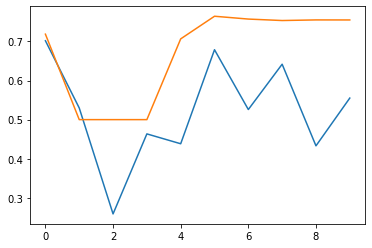

In [13]:
plt.plot(logs["auc"][2])
plt.plot(logs["val_auc"][2])
np.max(logs["val_auc"][2])